# Heart Disease Prediction Model
The dataset is from Kaggle, linked here: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset. However, the majority of its rows duplicate entries to greatly inflate its size, which are dropped before loading in the CSV file to match the original size of the source on UCI's Cleveland Heart Disease dataset.

This notebook builds a binary classification model to predict the presence of heart disease using clinical data. The goal is to identify high-risk individuals.

## Domain Background

Heart disease (coronary artery disease) is a condition caused by narrowed arteries reducing blood flow to the heart. Key clinical features include chest pain types, blood pressure, cholesterol levels, and exercise-induced symptoms. These features help predict the presence of heart disease using standard diagnostic tests like ECG and stress tests.

*This project is for educational purposes only and does not provide medical advice.*

---

## Dependencies
- pandas, numpy: for data loading, manipulation, and numerical operations

- matplotlib.pyplot, seaborn: for plotting histograms, heatmaps, ROC curves, and other visualizations

- sklearn.model_selection: for train/test splitting and k-fold cross-validation

- sklearn.pipeline, sklearn.compose.ColumnTransformer: for building end-to-end preprocessing and modeling pipelines

- sklearn.preprocessing: for scaling numeric features and one-hot encoding categoricals

- sklearn.impute: to handle missing values 

- sklearn.linear_model.LogisticRegression: the classifier used to predict heart disease presence

- sklearn.metrics: to evaluate model performance (ROC-AUC, F1 Score, confusion matrix, etc.)

- joblib: to save and load the trained model for reuse

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix, RocCurveDisplay
import joblib


sns.set_style('darkgrid')

## Data Exploration
We start by performing basic checks on the loaded DataFrame through Pandas.


In [15]:
def check_basic_info(df, show=True):
    """No return value, prints basic information & missing values in the given DataFrame."""
    if not show:
        return
    print(df.head())
    print("\nInfo: ")
    print(df.info())
    print("\nDescription: ")
    print(df.describe())
    print('\nMissing values: ')
    print(df.isnull().sum())

The dataset contains 1025 records spanning the following features:

- **age**: Numeric (years)  

- **sex**: Binary (0 = female, 1 = male) 

- **cp (chest pain type)**: Categorical  
  - 0 = typical angina  
  - 1 = atypical angina  
  - 2 = non-anginal pain  
  - 3 = asymptomatic  

- **trestbps (resting blood pressure)**: Numeric (mm Hg)  

- **chol (serum cholesterol)**: Numeric (mg/dl)  

- **fbs (fasting blood sugar > 120 mg/dl)**: Binary (1 = true, 0 = false) 

- **restecg (resting ECG results)**: Categorical  
  - 0 = normal  
  - 1 = ST-T wave abnormality  
  - 2 = probable or definite left ventricular hypertrophy  

- **thalach (maximum heart rate achieved)**: Numeric  

- **exang (exercise-induced angina)**: Binary (1 = yes, 0 = no)  

- **oldpeak**: Numeric (ST depression induced by exercise relative to rest; float)  

- **slope (of peak exercise ST segment)**: Categorical  
  - 0 = upsloping  
  - 1 = flat  
  - 2 = downsloping  

- **ca (number of major vessels visualized by fluoroscopy)**: Numeric (0–4)  

- **thal**: Categorical  
  - 1 = normal  
  - 2 = fixed defect  
  - 3 = reversible defect  

- **target**: Binary target variable (0 = no heart disease, 1 = presence of heart disease)


---

Pandas does not pick up on any NaN values, but we can see that "thal" contains a small amount of values of 0, though it is encoded to only contain values 1-3. 0 likely indicates missing records.

The columns "ca" and "thal" both involve the results of imaging tests, which are typically performed on patients who have identified risk. The inclusion of these features could imply that the individuals in the dataset have already been identified as high-risk for heart disease at the time of data collection. Therefore, this model predicts heart disease using all available data, and may not be suitable for early risk prediction when less clinical information is available.

## EDA

In [16]:
def plot_num_distribution(df, col, plot=True, save=False):
    """Plots a Histogram/KDE of a given col, designed for numericals."""
    plt.figure(figsize=(8,5))
    sns.histplot(df[col], bins=30, kde=True)
    plt.xlabel(col)
    plt.title(f"Distribution of {col}")
    plt.ylabel("Count")
    if save:
        plt.savefig(f"plot_num_distribution_{col}.png")
    if plot:
        plt.show()


def plot_cat_distribution(df, col, plot=True, save=False):
    """Plots countplots of a given col, designed for categoricals."""
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x=col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Distribution of {col}")
    if save:
        plt.savefig(f"plot_cat_distribution_{col}.png")
    if plot:
        plt.show()


def plot_cat_to_target(df, col, target='target', plot=True, save=False):
    """Plots mean of target variable by category in col."""
    plt.figure(figsize=(10,6))
    sns.barplot(data=df, x=col, y=target)
    plt.xticks(rotation=45)
    plt.title(f"Proportion of {target}=1 by {col}")
    plt.ylabel(f"Mean {target}")
    if save:
        plt.savefig(f"plot_target_{col}.png")
    if plot:
        plt.show()
    

def plot_num_to_target(df, col, target='target', plot=True, save=False):
    """Plots boxplots & violinplots of (numeric) col vs target."""
    plt.figure(figsize=(8,5))
    sns.violinplot(data=df, x=target, y=col, inner=None, color='steelblue')
    sns.boxplot(data=df, x=target, y=col, width=0.1, boxprops={'facecolor':'none'})
    plt.xlabel(target)
    plt.ylabel(col)
    plt.title(f"{target} by {col}")
    if save:
        plt.savefig(f"plot_target_{col}.png")
    if plot:
        plt.show()

def plot_binary_to_target(df, col, target='target', plot=True, save=False):
    """Plots countplots for binary cols vs target."""
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x=col, hue=target)
    plt.title(f"Countplot of {col} grouped by {target}")
    if save:
        plt.savefig(f"plot_target_{col}.png")
    if plot:
        plt.show()


def plot_corr_heatmap(df, num_cols, target='target', plot=True, save=False):
    "Plots a heatmap showing correlation between numerical cols."
    plt.figure(figsize=(12,10))
    corr = df[num_cols + [target]].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title("Correlation Heatmap")
    if save:
        plt.savefig(f"heatmap.png")
    if plot:
        plt.show()


def eda_utility(df, cat_cols, num_cols, bin_cols, target='target', plot=True, save=True):
    """Loops through all EDA functions above. Plots and/or saves according to parameters."""
    if not plot and not save:
        return
    
    plot_corr_heatmap(df, num_cols, target, plot=plot, save=save)
    plot_cat_distribution(df, target, plot=plot, save=save)

    for col in num_cols:
        plot_num_distribution(df, col, plot=plot, save=save)
        plot_num_to_target(df, col, plot=plot, save=save)
    
    for col in cat_cols + bin_cols:
        plot_cat_distribution(df, col, plot=plot, save=save)
        plot_cat_to_target(df, col, plot=plot, save=save)

    for col in bin_cols:
        plot_binary_to_target(df, col, plot=plot, save=save)

### EDA Takeaways
- The heatmap correlation analysis shows that maximum heart rate achieved (`thalach`), ST depression during exercise (`oldpeak`), and number of major vessels affected (`ca`) have the strongest relationships with heart disease status. Specifically, lower max heart rate, higher ST depression, and more affected vessels are associated with increased risk. Age also shows moderate correlation, influencing heart function indicators like max heart rate and ST depression.

- `restecg` has very few records labeled '2' (left ventricular hypertrophy), compared to many records labeled '0' (normal) or '1' (ST-T abnormality). Although the target mean for '2' is lower, the very small sample size makes this statistic unreliable. Because of the limited data, the model might not generalize well for this subgroup. To account for that, the feature will later be collapsed into a binary variable: '0' = normal and '1' = any abnormality (combining '1' and '2'). This reduces the chance of overfitting to a small class. More data would be needed to accurately model risk among individuals with left ventricular hyptertrophy.

- `thal` has a small amount of missing values, coded as 0. Because the amount is small, imputing with the most common category is a reasonable approach to maintain data integrity without losing other data in the samples.

- There is a class imbalance in `sex`, showing that the dataset is mostly men. The model may generalize better for men.

- `age` shows that the dataset focuses on middle-aged to senior adults, so the model may not generalize to younger individuals.

- The target variable is balanced, so no imbalance handling is needed for it.

- `chol` (cholesterol) and `trestbps` (resting blood pressure) are somewhat right-skewed and have wide ranges of values.


## Creating Model Pipeline

In [17]:
def clean_for_pipeline(df):
    """Cleaning steps before running data through model preprocessor pipeline."""
    df = df.copy()
    # Collapse restecg into binary
    df['restecg'] = df['restecg'].replace({2:1})
    # Replace thal 0 values with NaN
    df['thal'] = df['thal'].replace(0, np.nan)
    return df



def build_preprocessor(num_cols, cat_cols):
    """
    Builds the preprocessing pipelines for numeric and categorical features.
    Numerical cols: scales.
    Categorical cols: Imputes missing values (only in thal), uses one hot encoding.
    Returns preprocessing transformer.
    """

    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    return ColumnTransformer([
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])



def build_model(preprocessor):
    """Returns the pipeline of preprocessing & the Logistic Regression Classification model."""
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear', penalty='l2', C=1.0, class_weight='balanced', random_state=42))
    ])
    return model



def train_model(model, X, y, test_size=0.2):
    """Splits data into train and test sets, fits model, and returns the trained pipeline along with test sets."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    model.fit(X_train, y_train)
    return model, X_test, y_test


def evaluate_model_cv(model, X, y, cv=5):
    """K-fold cross-validation using roc_auc_score."""
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    print('\n')
    print(f"CV ROC-AUC scores: {scores}")
    print(f"Mean CV ROC-AUC: {scores.mean():.4f}")
    print(f"STD CV ROC-AUC: {scores.std():.4f}")
    print('\n')
    return scores



def evaluate_model(model, X_test, y_test):
    """Evaluates the trained model on the holdout set."""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    print("\nHoldout Test Set Eval:")
    print(f"\nROC-AUC: {auc:.4f}")
    print(f"\nF1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    RocCurveDisplay.from_estimator(model, X_test, y_test, name='LogisticRegression')
    plt.title("ROC Curve")
    plt.show()





def get_feature_importance(model, num_cols, cat_cols):
    """Plots the feature importance of trained model using logistic regression coefficients."""

    preprocessor = model.named_steps['preprocessor']
    classifier = model.named_steps['classifier']

    # create feature list: numerical plus decoded categorical names
    features = num_cols + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols))

    coefs = classifier.coef_[0]

    # creates df of features and corresponding coefficient
    coef_df = pd.DataFrame({
        'feature': features,
        'coefficient': coefs
    })

    # sorts coefficients by absolute value in new col
    coef_df['abs_coef'] = coef_df['coefficient'].abs()
    coef_df = coef_df.sort_values('abs_coef', ascending=False)


    # creates normalization obj in plt, based on min and max coefficient values
    normalized = plt.Normalize(coef_df['coefficient'].min(), coef_df['coefficient'].max())
    # defines color map
    cmap = sns.color_palette('coolwarm', as_cmap=True)
    # applies color map based on normalized coefficients to get positive/negative effect visualized
    colors = cmap(normalized(coef_df['coefficient']))


    # plotting
    plt.figure(figsize=(10,6))
    sns.barplot(x='coefficient', y='feature', data=coef_df, palette=colors)
    plt.title('Logistic Regression Feature Importance')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.grid(True)
    plt.show()



def run_pipeline(df, num_cols, cat_cols, target='target'):
    """Runs above pipeline & evaluation steps on given data, returns the model."""

    # define column types
    

    # define feature and target space
    X = df.drop(columns=[target])
    y = df[target] 

    # creates preprocessor & model pipeline
    preprocessor = build_preprocessor(num_cols, cat_cols)
    model_pipeline = build_model(preprocessor)
    
    
    # cv scores
    evaluate_model_cv(model_pipeline, X, y, cv=5)

    # train and evaluate model
    model, X_test, y_test = train_model(model_pipeline, X, y)

    evaluate_model(model, X_test, y_test)
    

    return model



In [18]:
def save_model(model, save=True):
    """Saves the final model."""
    if not save:
        return
    joblib.dump(model, 'heart_disease_model.joblib')

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trestbps  302 non-null    int64  
 4   chol      302 non-null    int

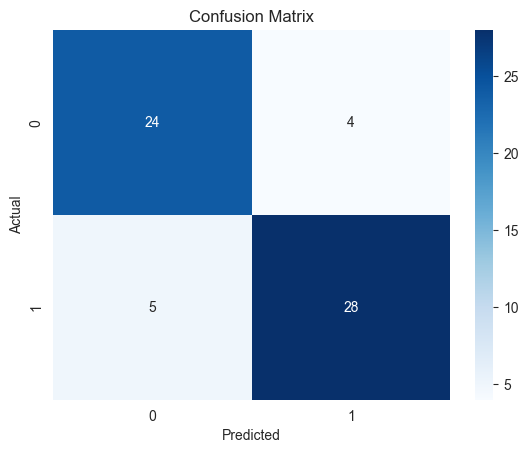

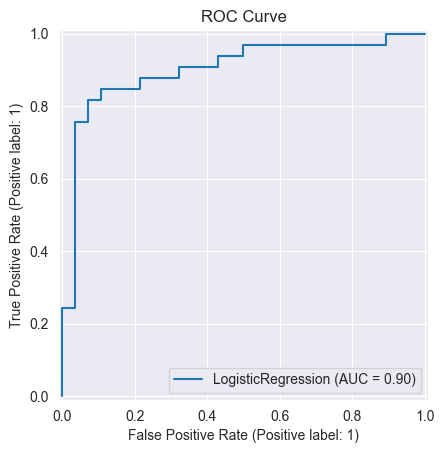

C:\Users\Fi\AppData\Local\Temp\ipykernel_29492\248975737.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=coef_df, palette=colors)
C:\Users\Fi\AppData\Local\Temp\ipykernel_29492\248975737.py:125: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x='coefficient', y='feature', data=coef_df, palette=colors)


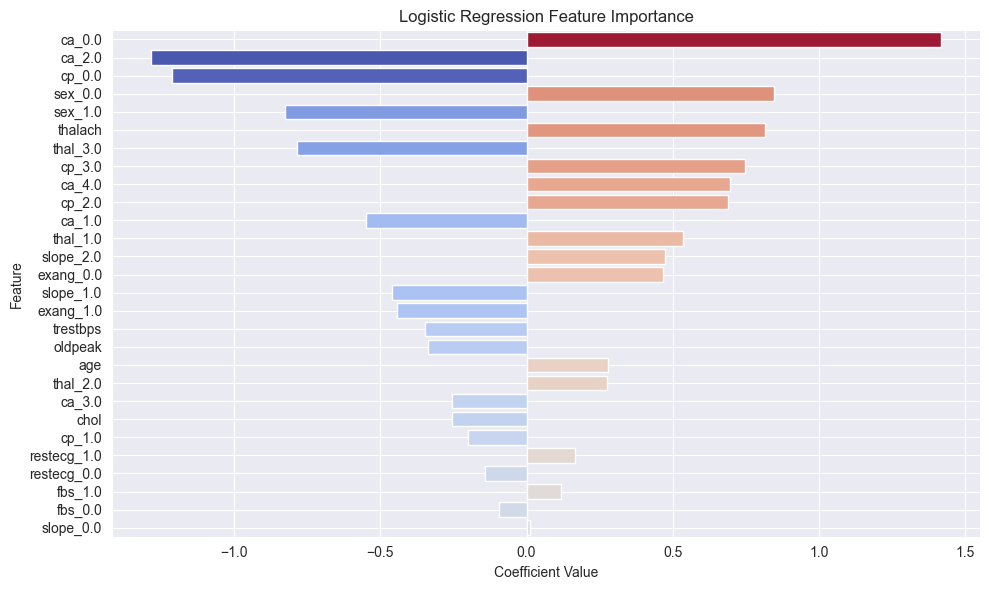

In [19]:
# main driver function
def main():

    # load in dataset with duplicates removed
    df = pd.read_csv('heart.csv')

    
    # inspect data
    check_basic_info(df, show=True)

    # EDA, first defining col types for it (note: some numerical cols function as categoricals)
    eda_num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    eda_cat_cols = ['cp',  'restecg', 'slope', 'thal', 'ca']
    eda_bin_cols = ['sex', 'fbs', 'exang']
    eda_utility(df, eda_cat_cols, eda_num_cols, eda_bin_cols, plot=False, save=False)

    # Define col types for model
    model_num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    model_cat_cols = ['cp',  'restecg', 'slope', 'thal', 'ca', 'sex', 'fbs', 'exang']
    
    # Prepare data for model, run all model & evaluation steps
    df = clean_for_pipeline(df)
    model = run_pipeline(df, model_num_cols, model_cat_cols)
    get_feature_importance(model, model_num_cols, model_cat_cols)

    # Optionally save model
    save_model(model, save=False)



    
if __name__ == "__main__":
    main()

## Model Performance & Generalizability
5-fold cross validation shows that the data in question has a mean ROC-AUC of approximately 0.91 (± 0.04), indicating solid performance. It shows moderate variability, which is expected given the small dataset size. In order to create a model that stabilizes further and generalizes to wider data, it would be important to gather a larger dataset. Further improvements based on the current data may risk overfitting the model to noise within this dataset rather than capturing true general signal.


## Feature Contributions
The feature importance plot displays model coefficients, showing how each feature affects prediction. Red features on the right contribute to the chance of heart disease diagnosis, while blue features on the left contribute against. The intensity of the color and length of the bar indicate how important that feature is weighted in making predictions.